# MindSpore应用，毒蘑菇识别
全世界已知有2000多种野生食用菌的种类，云南占全国的80%、全世界的40%以上，全省境内有126个县城出产野生菌，每年吃菌的时间长达半年。

据说，每个云南人都有一个因吃菌中过毒的朋友。了解蘑菇种类，能帮助食客们分别毒蘑菇与可食用蘑菇。

本实验将使用蘑菇数据集，训练一个能分辨蘑菇种类的模型。

数据集介绍：
* 蘑菇数据集包含9个类，每个类有300~1600个长宽不等的彩色图像。
* 9个类完全相互排斥，且类之间没有重叠。
* 本实验使用ImageFolder格式管理数据集，每一类图片整理成单独的一个文件夹，数据集结构如下：
```bash
└─ImageFolder
    ├─train  
    │   class1Folder
    │   class2Folder
    │   ......
    └─test
        class1Folder
        class2Folder
        ......
```
* 数据来源：https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images

<img src="image/01.png">

数据集包含以下9种蘑菇
* Agaricus：双孢蘑菇，伞菌目，蘑菇科，蘑菇属，广泛分布于北半球温带，无毒。
* Amanita：毒蝇伞，伞菌目，鹅膏菌科，鹅膏菌属，主要分布于我国黑龙江、吉林、四川、西藏、云南等地，有毒。
* Boletus：丽柄牛肝菌，伞菌目，牛肝菌科，牛肝菌属，分布于云南、陕西、甘肃、西藏等地，有毒。
* Cortinarius：掷丝膜菌，伞菌目，丝膜菌科，丝膜菌属，分布于湖南等地(夏秋季在山毛等阔叶林地上生长)，有毒。
* Entoloma：霍氏粉褶菌，伞菌目，粉褶菌科，粉褶菌属，主要分布于新西兰北岛和南岛西部，有毒。
* Hygrocybe：浅黄褐湿伞，伞菌目，蜡伞科，湿伞属，分布于香港(见于松仔园)，有毒。
* Lactarius：松乳菇，红菇目，红菇科，乳菇属，广泛分布于亚热带松林地，无毒。
* Russula：褪色红菇，伞菌目，红菇科，红菇属，分布于河北、吉林、四川、江苏、西藏等地，无毒。
* Suillus：乳牛肝菌，牛肝菌目，乳牛肝菌科，乳牛肝菌属，分布于吉林、辽宁、山西、安徽、江西、浙江、湖南、四川、贵州等地，无毒。

### 环境准备

本实验需要以下第三方库：
1. MindSpore 1.1.1
2. Numpy 1.17.5
3. matplotlib 3.3.4
4. easydict 1.9

Python 环境导入

In [1]:
import mindspore.dataset as ds # 数据集载入
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor # 回调函数
from mindspore.train import Model # 承载网络结构
from mindspore import load_checkpoint # 读取最佳参数
from mindspore import context # 设置mindspore运行的环境

from easydict import EasyDict as ed # 超参数保存
import numpy as np # numpy
import matplotlib.pyplot as plt # 可视化

# 文件处理相关
import os

# 华为云文件传输相关
# import moxing

MindSpore 环境设置

In [2]:
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target) # 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: CPU
dataset_sink_mode: False


数据集下载和解压缩

In [3]:
# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/data.zip）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='data.zip') # 下载数据

# 解压缩数据包
os.system('unzip data.zip')

输入数据路径（例：obs://桶名/目录/data.zip）
数据路径：obs://mindspore1706/mushroom/data.zip


0

### 参数设置

In [4]:
# 数据路径
train_path = os.path.join('dataset', 'train')
test_path = os.path.join('dataset', 'test')

# 超参数
config = ed({
    # 训练参数
    'batch_size': 32,
    'epochs': 150,
    
    #网络参数
    'class_num': 9,

    # 动态学习率调节
    'warmup_epochs': 5,
    'lr_init': 0.01,
    'lr_max': 0.1,

    # 优化器参数
    'momentum': 0.9,
    'weight_decay': 4e-5})

### 数据展示

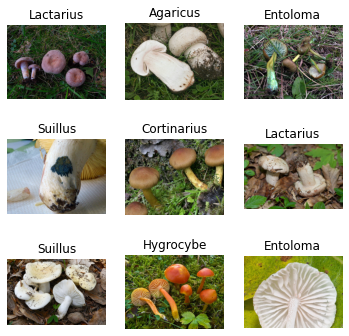

In [5]:
# 创建图像标签列表
category_dict = {0:'Agaricus',1:'Amanita',2:'Boletus',3:'Cortinarius',4:'Entoloma',
                 5:'Hygrocybe',6:'Lactarius',7:'Russula',8:'Suillus'}

# 载入展示用数据
demo_ds = ds.ImageFolderDataset(test_path, decode=True)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_ds.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i +=1
    if i > 9 :
        break

plt.show()

### 数据处理

计算数据集平均数和标准差，数据归一化时使用

In [6]:
train_ds = ds.ImageFolderDataset(train_path, decode=True)
#计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray( [np.mean(x['image'], axis=(0, 1)) for x in train_ds.create_dict_iterator(output_numpy=True)] )
RGB_mean = tuple(np.mean(tmp, axis=(0)))
RGB_std = tuple(np.std(tmp, axis=(0)))

print(RGB_mean)
print(RGB_std)

(99.96900945227065, 94.50353387466772, 72.11369071011747)
(23.190086574375275, 20.17198902609836, 21.21375858611869)


因蘑菇数据集各个类的样本数差异较大，为确保评估公正性，这里对验证集使用PKSampler进行平均采样（欠采样）。

In [7]:
from preprocess import create_dataset

### 网络定义
本实验使用ResNet50网络。

ResNet出自论文《Deep Residual Learning for Image Recognition》。

ResNet又称残差网络，是由Microsoft Research提出的一种卷积神经网络，在2015年的ImageNet竞赛中获得图像分类和物体识别的优胜。ResNet提出了“残差块”的概念，通过跳跃连接的方式缓解了在深度神经网络中增加深度带来的梯度消失问题，这使得ResNet能够通过增加相当的深度来提高准确率。

残差块示意图：
<img src="image/02.png">

In [8]:
# 这里将网络分为backbone和head，backbone是ResNet包含残差块的部分，head是最后的全连接层。
from network import resnet50_backbone, resnet50_head

# 最终网络由backbone和head组成。
class ResNet50(nn.Cell):
    """
    ResNet architecture.

    Args:
        backbone (Cell): ResNet50 backbone网络
        head (Cell): ResNet50 head网络
    Returns:
        Tensor, 输出张量

    Examples:
        >>> ResNet50(resnet_backbone,
        >>>          resnet_head)
    """

    def __init__(self, backbone, head):
        super(ResNet50, self).__init__()

        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


### 模型训练

载入数据集

In [9]:
# 训练集
train_data = create_dataset(data_path=train_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='train',
                            repeat_num=1)

# 测试集
test_data = create_dataset(data_path=test_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='test',
                            repeat_num=1)

设定动态学习率，加速模型收敛。

本实验学习率函数图如下：

<img src="image/03.png">

In [10]:
from lr_scheduler import get_lr

# 训练step总数
train_step_size = train_data.get_dataset_size()

# 学习率数组
lr = get_lr(total_epochs=config.epochs, 
            steps_per_epoch=train_step_size,
            lr_init=config.lr_init,
            lr_max=config.lr_max,
            warmup_epochs=config.warmup_epochs)


定义网络、损失函数、优化器、模型

In [11]:
# 网络
backbone_net = resnet50_backbone() # backbone网络，保存后能提供后续迁移学习使用
head_net = resnet50_head(config.class_num) # head网络，resnet50最后的全连接层
net = ResNet50(backbone_net, head_net)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
opt = nn.Momentum(net.trainable_params(), lr, momentum=config.momentum, weight_decay=config.weight_decay)

# 模型
model = Model(net, loss_fn = net_loss,
              optimizer = opt, metrics = {'accuracy','loss'})

自定义回调函数（EvalHistory中新增保存最佳模型的backbone网络参数的功能）

In [12]:
from callbacks import TrainHistroy, EvalHistory

设置回调函数

In [13]:
time_cb = TimeMonitor(data_size=train_step_size) # 监控每次迭代的时间
loss_cb = LossMonitor() # 监控loss值
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           backbone = backbone_net,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

cb = [time_cb, loss_cb, train_hist_cb, eval_hist_cb]

训练模型

In [ ]:
model.train(config.epochs, train_data, callbacks=cb)

[WARNING] ME(3980:13044,MainProcess):2023-05-26-15:09:11.668.710 [mindspore\train\model.py:500] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


### 模型评估

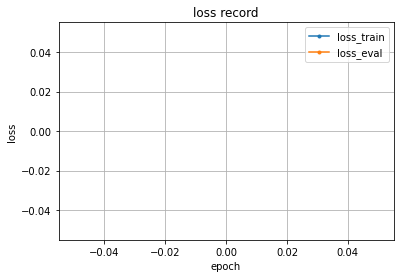

In [25]:
# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist)

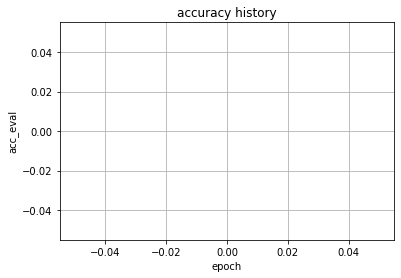

In [26]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist)

In [14]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
load_checkpoint('best_param.ckpt', net=net)
res = model.eval(test_data, dataset_sink_mode=False)
print(res)

ValueError: The checkpoint file does not exist.

## 效果展示

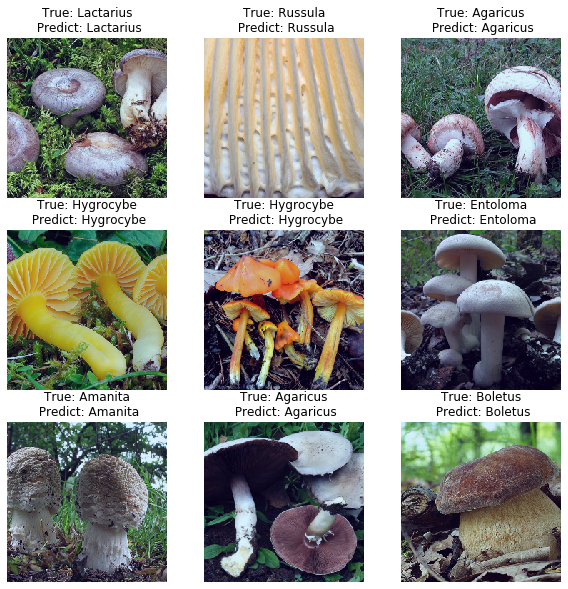

In [18]:
# 创建图像标签列表
category_dict = {0:'Agaricus',1:'Amanita',2:'Boletus',3:'Cortinarius',4:'Entoloma',
                 5:'Hygrocybe',6:'Lactarius',7:'Russula',8:'Suillus'}

ds_test_demo = create_dataset(test_path, mean=RGB_mean, std=RGB_std, batch_size=1, usage='test')

# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in ds_test_demo.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0) # 删除batch维度
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show()

### 模型保存
若要保存模型参数文件（ckpt），停止ModelArts环境前需先将保存在ModelArts暂存的模型参数文件上传到OBS。

In [19]:
# 将ckpt上传到OBS
print('输入目标路径（例：obs://桶名/目录/best_param_backbone.ckpt）')
dst = input('目标路径：')
moxing.file.copy_parallel(src_url='best_param_backbone.ckpt', dst_url=dst)

输入目标路径（例：obs://桶名/目录/best_param_backbone.ckpt）
目标路径：obs://mindspore1706/mushroom/best_param_backbone.ckpt
